# Triple Stratified KFold CV with TFRecords
This is a simple starter notebook for Kaggle's Melanoma Comp showing triple stratifed KFold with TFRecords. Triple stratified KFold is explained [here][2]. There are many configuration variables below to allow you to experiment. Use either GPU or TPU. You can control which size images are loaded, which efficientNets are used, and whether external data is used. You can experiment with different data augmentation, model architecture, loss, optimizers, and learning schedules. The TFRecords contain meta data, so you can input that into your CNN too. 

**NOTE:** this notebook lets you run a different experiment in each fold if you want to run lots of experiments. (Then it is like running multiple holdout validaiton experiments but in that case note that the overall CV score is meaningless because LB will be much higher when the multiple experiments are ensembled to predict test). **If you want a proper CV with a reliable overall CV score you need to choose the same configuration for each fold.**

This notebook follows the 5 step process presented in my "How to compete with GPUs Workshop" [here][1]. Some code sections have been reused from AgentAuers' great notebook [here][3]

[1]: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
[3]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

# Kaggle's SIIM-ISIC Melanoma Classification
In this competition, we need to identify melanoma in images of skin lesions. Full description [here][1]. This is a very challenging image classification task as seen by looking at the sample images below. Can you recognize the differences between images? Below are example of skin images with and without melanoma.

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification

In [1]:
Kaggle = False
Colab = !Kaggle

In [2]:
import os, sys
from pathlib import Path

if Colab:
    from google.colab import drive
    drive.mount('/content/drive')

    path = "/content/drive/My Drive"
    os.chdir(path)
    os.listdir(path)
else:
    from kaggle_datasets import KaggleDatasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if Kaggle:
    BASEPATH = "../input/siim-isic-melanoma-classification"
    outdir = '.'
else:
    PATH = 'siim/'
    BASEPATH = PATH + 'siim-isic-melanoma-classification'
    outdir = Path(PATH+'res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = Path(PATH+'res/efficientnet-res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    MODELNAME = "EF7-512"
    VERSION = '{}'.format(MODELNAME)
    outdir = os.path.join(outdir, VERSION)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    # from datetime import datetime, timedelta
    # dateTimeObj = datetime.now()
    # timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H")
    timestampStr = 'all-kfold-hairaug-norm'
    outdir = os.path.join(outdir, timestampStr)
    if not os.path.exists(outdir):
        os.mkdir(outdir)   

In [4]:
import cv2, pandas as pd, matplotlib.pyplot as plt
if Kaggle:
    train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
    print('Examples WITH Melanoma')
    imgs = train.loc[train.target==1].sample(10).image_name.values
    plt.figure(figsize=(20,8))
    for i,k in enumerate(imgs):
        img = cv2.imread('../input/jpeg-melanoma-128x128/train/%s.jpg'%k)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.subplot(2,5,i+1); plt.axis('off')
        plt.imshow(img)
    plt.show()
    print('Examples WITHOUT Melanoma')
    imgs = train.loc[train.target==0].sample(10).image_name.values
    plt.figure(figsize=(20,8))
    for i,k in enumerate(imgs):
        img = cv2.imread('../input/jpeg-melanoma-128x128/train/%s.jpg'%k)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.subplot(2,5,i+1); plt.axis('off')
        plt.imshow(img)
    plt.show()

# Initialize Environment

In [5]:
!pip install -q efficientnet >> /dev/null

In [6]:
import pandas as pd, numpy as np
# from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [7]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

## Configuration
In order to be a proper cross validation with a meaningful overall CV score (aligned with LB score), **you need to choose the same** `IMG_SIZES`, `INC2019`, `INC2018`, and `EFF_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds. 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [8]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
# SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
# IMG_SIZES = [384,384,384,384,384]
IMG_SIZES = [600,600,600,600,600]
img_read_size = 768
IMG_READ_SIZES = [img_read_size,img_read_size,img_read_size,img_read_size,img_read_size]
img_crop_size = 584

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [8]*FOLDS
EPOCHS = [22]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [7,7,7,7,7]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 25

n_max = 10

In [9]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.48.8.42:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.48.8.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.8.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

In [10]:
## melanoma dataset
gcs_path = []
gcs_path.append('gs://kds-2b28e4519749435c2fb543681ca66aaee6159d9fcc906d5b26f8916e') #192
gcs_path.append('gs://kds-dffc4fc041639d63f5cb739622149422dbd485d2bd7f66a514c67fae') #256
gcs_path.append('gs://kds-30a0c9f78d3675d10f6b6546877a20d24100810cef730172979b36af') #384
gcs_path.append('gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b') #512
gcs_path.append('gs://kds-79662e42fc05f15bf1149504a028b04213a0218d96b9180368ce47a5') #768

## isic dataset
gcs_path2 = []
gcs_path2.append('gs://kds-c9c10ac29c6818441da475638226dfcf3d12806980a23f179a21d826') #192-2018
gcs_path2.append('gs://kds-c85f3ec67d1d7853bb9f2b928a1d69ac62ae7d52146c54a65b69f5bb') #256-2018
gcs_path2.append('gs://kds-9fc526a7f92f5454bc790655a916878883ad270d1e13c91e7d527659') #384-2018
gcs_path2.append('gs://kds-25423645f76650f9220fbd3613366c3c5a524b3a7d7663b6e3137c57') #512-2018
gcs_path2.append('gs://kds-d647c34c4541dfa651df0eeb57cb8f7702660f0881153486056f8448') #768-2019 

gcs_path_dict = {192:0,256:1,384:2,512:3,768:4}

gcs_path_hairs = 'gs://kds-0f1845648605e1d5c6a531816acb4e993458e02c32d8f4d5bc6bf4cf'

In [11]:
# Roman's images of hairs
hair_images=tf.io.gfile.glob(gcs_path_hairs + '/*.png')

In [12]:
print(gcs_path[gcs_path_dict[512]])
print(gcs_path2[gcs_path_dict[512]])

gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b
gs://kds-25423645f76650f9220fbd3613366c3c5a524b3a7d7663b6e3137c57


In [13]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
if Kaggle:
    for i,k in enumerate(IMG_READ_SIZES):
        GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
        GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
else:
    for i,k in enumerate(IMG_READ_SIZES):
        GCS_PATH[i] = gcs_path[gcs_path_dict[k]]
        GCS_PATH2[i] = gcs_path2[gcs_path_dict[k]]
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [14]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [15]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [16]:
hair_images_tf=tf.convert_to_tensor(hair_images)
scale=tf.cast(IMG_SIZES[0]/256, dtype=tf.int32)

In [17]:
def hair_aug(image):
    # Copy the input image, so it won't be changed
    img=tf.identity(image) 
    # Randomly choose the number of hairs to augment (up to n_max)
    n_hairs = tf.random.uniform(shape=[], maxval=tf.constant(n_max)+1, 
                                dtype=tf.int32)
    
    im_height=tf.shape(img)[1]
    im_width=tf.shape(img)[0]
    
    if n_hairs == 0:
        return image

    for _ in tf.range(n_hairs):

        # Read a random hair image
        i=tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0], 
                            dtype=tf.int32)
        fname=hair_images_tf[i]

        bits = tf.io.read_file(fname)
        hair = tf.image.decode_jpeg(bits)
        
        # Rescale the hair image to the right size (256 -- original size)
        new_width=scale*tf.shape(hair)[1]
        new_height=scale*tf.shape(hair)[0]
        hair = tf.image.resize(hair, [new_height, new_width])

        
        # Random flips of the hair image
        hair = tf.image.random_flip_left_right(hair)
        hair = tf.image.random_flip_up_down(hair)
        # Random number of 90 degree rotations
        n_rot=tf.random.uniform(shape=[], maxval=4,
                                dtype=tf.int32)
        hair = tf.image.rot90(hair, k=n_rot)
        
        h_height=tf.shape(hair)[0]
        h_width=tf.shape(hair)[1]
        
        roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, 
                                    dtype=tf.int32)
        roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, 
                                    dtype=tf.int32)


        roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

        # Convert the hair image to grayscale 
        # (slice to remove the trainsparency channel)
        hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])

        mask=hair2gray>10

        img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask),
                                          dtype=tf.float32))
        hair_fg = tf.multiply(tf.cast(hair[:, :, :3], dtype=tf.int32),
                              tf.cast(tf.image.grayscale_to_rgb(mask), 
                                      dtype=tf.int32
                                      )
                             )

        dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32)/255)

        paddings = tf.stack([
            [roi_h0, im_height-(roi_h0 + h_height)], 
            [roi_w0, im_width-(roi_w0 + h_width)],
            [0, 0]
        ])

        # Pad dst with zeros to make it the same shape as image.
        dst_padded=tf.pad(dst, paddings, "CONSTANT")
        # Create a boolean mask with zeros at the pixels of
        # the augmentation segment and ones everywhere else
        mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
        mask_img=~tf.cast(mask_img, dtype=tf.bool)
        # Make a hole in the original image at the location
        # of the augmentation segment
        img_hole=tf.multiply(img, tf.cast(mask_img, dtype=tf.float32))
        # Inserting the augmentation segment in place of the hole
        img=tf.add(img_hole, dst_padded)
        
    return img

In [18]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def norm_image(img):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img -= mean
    img /= std
    # mean_tensor = K.constant(-np.array(mean), tf.float32)
    # std_tensor = K.constant(np.array(std), tf.float32)
    # img = K.bias_add(img, mean_tensor, "channels_last")
    # img /= std_tensor
    return img

def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [dim, dim])
    img = tf.cast(img, tf.float32) / 255.0
    if augment:
        img = hair_aug(img)
        img = transform(img,DIM=dim)
        img = tf.image.random_crop(img, [img_crop_size, img_crop_size, 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
    else:
        img = tf.image.central_crop(img, img_crop_size / img_read_size)  
    img = norm_image(img)               
    img = tf.image.resize(img, [dim, dim])
    img = tf.reshape(img, [dim, dim, 3])
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [19]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [20]:
_DECAY = 0.0001


class AttentionModel(tf.keras.Model):
  """Instantiates attention model.
  Uses two [kernel_size x kernel_size] convolutions and softplus as activation
  to compute an attention map with the same resolution as the featuremap.
  Features l2-normalized and aggregated using attention probabilites as weights.
  """

  def __init__(self, kernel_size=1, decay=_DECAY, name='attention'):
    """Initialization of attention model.
    Args:
      kernel_size: int, kernel size of convolutions.
      decay: float, decay for l2 regularization of kernel weights.
      name: str, name to identify model.
    """
    super(AttentionModel, self).__init__(name=name)

    # First convolutional layer (called with relu activation).
    self.conv1 = tf.keras.layers.Conv2D(
        512,
        kernel_size,
        kernel_regularizer=tf.keras.regularizers.l2(decay),
        padding='same',
        name='attn_conv1')
    self.bn_conv1 = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')

    # Second convolutional layer, with softplus activation.
    self.conv2 = tf.keras.layers.Conv2D(
        1,
        kernel_size,
        kernel_regularizer=tf.keras.regularizers.l2(decay),
        padding='same',
        name='attn_conv2')
    self.activation_layer = tf.keras.layers.Activation('softplus')

  def call(self, inputs, training=True):
    x = self.conv1(inputs)
    x = self.bn_conv1(x, training=training)
    x = tf.nn.relu(x)

    score = self.conv2(x)
    prob = self.activation_layer(score)

    # L2-normalize the featuremap before pooling.
    inputs = tf.nn.l2_normalize(inputs, axis=-1)
    feat = tf.multiply(inputs, prob)
    # feat = tf.reduce_mean(tf.multiply(inputs, prob), [1, 2], keepdims=False)

    return feat, prob, score

In [21]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    attention_model = AttentionModel(name='attention')
    x, _, _ = attention_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [22]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [23]:
import gc
TRAIN = False

In [29]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = TRAIN

# skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
# oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
# preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    if fold < 3:
        continue
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(outdir,'fold-%i.h5'%fold), monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    svauc = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(outdir,'fold-%i-bestvalauc.h5'%fold), monitor='val_auc', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
   
    if TRAIN:
        # TRAIN
        print('Training...')
        history = model.fit(
            get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                    dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
            epochs=EPOCHS[fold], callbacks = [sv,svauc,early_stopping_cb,get_lr_callback(BATCH_SIZES[fold])], 
            steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
            validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                    repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
            verbose=VERBOSE
        )
    
    print('Loading best model...')
    model.load_weights(os.path.join(outdir,'fold-%i.h5'%fold))
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]

    del ds_valid, ds, ds_test
    gc.collect()
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    if TRAIN:
        oof_val.append(np.max( history.history['val_auc'] ))
        print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    else:
        print('#### FOLD %i OOF AUC with TTA = %.3f'%(fold+1, auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        epoch = len(history.history['auc'])
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(epoch),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(epoch),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(epoch),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(epoch),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  

INFO:tensorflow:Initializing the TPU system: grpc://10.48.8.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.8.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 4
#### Image Size 600 with EfficientNet B7 and batch_size 64
#### Using 2018+2017 external data
#########################
Loading best model...
Predicting OOF with TTA...
637/636 [==============================] - 1099s 2s/step
Predicting Test with TTA...
1073/1072 [==============================] - 1858s 2s/step
#### FOLD 4 OOF AUC with TTA = 0.925


INFO:tensorflow:Initializing the TPU system: grpc://10.48.8.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.8.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 5
#### Image Size 600 with EfficientNet B7 and batch_size 64
#### Using 2018+2017 external data
#########################
Loading best model...
Predicting OOF with TTA...
641/640 [==============================] - 1104s 2s/step
Predicting Test with TTA...
1073/1072 [==============================] - 1868s 2s/step
#### FOLD 5 OOF AUC with TTA = 0.923


In [30]:
ls siim/res/efficientnet-res/EF7-512/all-kfold-hairaug-norm/

fold-0-bestvalauc.h5  fold-1-bestvalauc.h5  fold-2-bestvalauc.h5  fold-3.h5
fold-0.h5             fold-1.h5             fold-2.h5             fold-4.h5


## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [31]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv(os.path.join(outdir,'oof.csv'),index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.923


,image_name,target,pred,fold
0,ISIC_2637011,0,0.028464,0
1,ISIC_0076262,0,0.027360,0
2,ISIC_0074268,0,0.025986,0
3,ISIC_0015719,0,0.027409,0
4,ISIC_0082543,0,0.027564,0


# Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

# Submit To Kaggle

In [32]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [33]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(os.path.join('submission.csv'), index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.026255
1443,ISIC_0052349,0.026749
3120,ISIC_0058510,0.025282
4870,ISIC_0073313,0.024700
5494,ISIC_0073502,0.032727


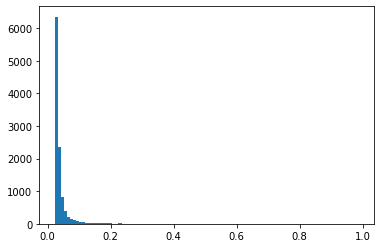

In [34]:
plt.hist(submission.target,bins=100)
plt.show()

In [35]:
submission.to_csv(os.path.join(outdir, 'submission.csv'), index=False)

In [36]:
print(outdir)

siim/res/efficientnet-res/EF7-512/all-kfold-hairaug-norm
